In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import string #if you wish to remove punctuation/digits
import glob

C:\Users\all\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Import data

In [12]:
os.chdir(r'E:\Capstone\aflac\final files\reddit')
files_all = glob.glob('*.txt')

In [13]:
files_all

['Aflac Accident Insurance.txt',
 'Aflac Also, POS vs HSA.txt',
 'Aflac Cancer Indemnity Insurance.txt',
 'Aflac CEO talks benefits for employees after tax reform.txt',
 'Aflac commission chargebacks.txt',
 'Aflac Denied My Claim Because Blank.txt',
 'Aflac for Maternity Leave.txt',
 'Aflac Teacher help needed.txt',
 'Aflac worth it.txt',
 'Aflac....yes or no.txt',
 'aflac_denied_my_claim_for_disability_because.txt',
 'Boss wants to retroactively charge me for Aflac insurance that she has been paying for, but has not been deducted from my paycheck for nearly 2 years.txt',
 'Doe aflac make sense for me.txt',
 'Father passed before life insurance activated. Chubb and Aflac still taking money from mothers paychecks even after begging to cancel..txt',
 'got_offered_job_at_Aflac.txt',
 'How do you guys feel about Aflac.txt',
 'I tried to sell Aflac before I got a real job... And six months later I owe them $200.txt',
 'Is AFLAC worth it Feels like a bit of a scam.txt',
 'Is supplemental ins

In [14]:
def get_comments(files):
    comments = []
    for fl in files:
        with open(fl, 'r', encoding='utf-8',errors='ignore') as f:
            f.seek(0)
            for line in f.readlines():
                line = line.strip()
                if len(line)>0:
                    comments.append(line)
    return comments

In [7]:
# Store the links
for fl in files:
    print(fl)
    with open(fl, 'r', encoding='utf-8',errors='ignore') as f:
        f.seek(0)
        for line in f.readlines():
            line = line.strip()
            if 'https' in line:
                print(line)

Aflac Accident Insurance.txt
Aflac Also, POS vs HSA.txt
Aflac Cancer Indemnity Insurance.txt
Aflac CEO talks benefits for employees after tax reform.txt
Proof: https://imgur.com/a/z1UM2
Aflac commission chargebacks.txt
Aflac Denied My Claim Because Blank.txt
https://webordering.aflac.com/PDF/A57675MA.PDF
File a complaint with the [Washington State Insurance Commissioner](https://www.insurance.wa.gov/file-complaint-or-check-your-complaint-status).
* [General Rule 1](https://www.reddit.com/r/legaladvice/wiki/index#wiki_1.__no_offers_to_send_or_accept_private_messages.2C_chats.2C_or_anything_similar.)
*Please [read our subreddit rules](https://www.reddit.com/r/legaladvice/wiki/index#wiki_general_rules).  If after doing so, you believe this was in error, or you’ve edited your post to comply with the rules, [message the moderators](https://www.reddit.com/message/compose?to=%2Fr%2FLegalAdvice).*
Aflac for Maternity Leave.txt
Aflac Teacher help needed.txt
Aflac worth it.txt
Aflac....yes or no

# Clean the data

In [5]:
# Lemmatiztion
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# Get stopwords
stop_words = set(stopwords.words('english')) 
stop_list = list(stop_words)
stop_list.append('aflac')

def remove_special_char(text):
    '''
    Utility function to clean text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z]+)|([^A-Za-z \t])|(\w+:\/\/\S+)", " ", str(text)).split())

def pos_tags(text):
    tokens = word_tokenize(text)
    return ' '.join([word for (word, pos) in nltk.pos_tag(tokens) if pos[:2] in ['NN','JJ','RB','VB']])

#function to  Clean the tweet
def clean(text):
    clean_txt = remove_special_char(text)
    postags = pos_tags(clean_txt)
    tokens = word_tokenize(postags)
    tokens_lower = [token.lower() for token in tokens if len(token) > 3]
    tokens_stop = [token for token in tokens_lower if token not in stop_list]
    tokens_clean = [get_lemma(token) for token in tokens_stop]
    return ' '.join(tokens_clean)

<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence \w
<input>:19: DeprecationWarning: invalid escape sequence 

In [15]:
# Get all comments
cmts = get_comments(files_all)

In [17]:
def clean_comment(comments):
    clean_comments = []
    for c in comments:
        cleaned = clean(c)
        if len(cleaned)>0:
            clean_comments.append(cleaned)
    return clean_comments

In [23]:
def clean_token(comments):
    clean = clean_comment(comments)  
    clean_tokens = []
    for c in clean:
        tokens = word_tokenize(c)
        clean_tokens.append(tokens)
    return clean_tokens

In [27]:
def final_tokens(comments,remove):
    tokens = clean_token(comments)
    tokens_new = []
    for i in tokens:
        tokens_new.append([token for token in i if token not in remove])
    return tokens_new

In [16]:
len(cmts)

740

In [18]:
clean_cmts = clean_comment(cmts)

In [20]:
len(clean_cmts)

714

In [21]:
cmts[:5]

['Insurance is always a gamble. You could pay 100s of thousands of dollars over the course of your life and never have more than some routine health costs and then get killed instantly in a car accident on your 80th birthday. Or you could turn 28 and be told you have cancer and get 100s of thousands in health care paid for.',
 'The biggest thing to figure out is, is if what you are paying makes sense for the risks you are at. A risk is both the likely hood it will happen, and the cost when it happens. Then compare that to what they would pay.',
 "If they will only 5000 max and you are paying in 350 a year, that's not a great deal, but if they will pay out 100k max, maybe its a better deal.",
 "You've just gotta research the details of your policy and the make an educated guess if it is something you should be covered for.",
 'Thanks for the input.']

In [22]:
clean_cmts[:5]

['insurance always gamble thousand dollar course life never routine health costs kill instantly accident birthday turn tell cancer thousand health care pay',
 'big thing figure pay make sense risk risk likely hood happen cost happen compare',
 'pay year great deal maybe better deal',
 'research details policy make educate guess something cover',
 'thanks input']

In [24]:
clean_tkns = clean_token(cmts)
clean_tkns[:5]

[['insurance',
  'always',
  'gamble',
  'thousand',
  'dollar',
  'course',
  'life',
  'never',
  'routine',
  'health',
  'costs',
  'kill',
  'instantly',
  'accident',
  'birthday',
  'turn',
  'tell',
  'cancer',
  'thousand',
  'health',
  'care',
  'pay'],
 ['big',
  'thing',
  'figure',
  'pay',
  'make',
  'sense',
  'risk',
  'risk',
  'likely',
  'hood',
  'happen',
  'cost',
  'happen',
  'compare'],
 ['pay', 'year', 'great', 'deal', 'maybe', 'better', 'deal'],
 ['research',
  'details',
  'policy',
  'make',
  'educate',
  'guess',
  'something',
  'cover'],
 ['thanks', 'input']]

In [25]:
from wordcloud import WordCloud
def create_cloud(comments):
    clean = clean_comment(comments)
    text = " ".join(txt for txt in clean)
    words = []
    tokens = nltk.tokenize.word_tokenize(text)
    fd = nltk.FreqDist(tokens)
    for word, frequency in fd.most_common(100):
        words.append(word)
    print(words)
    wc = WordCloud( max_words=100,background_color="white").generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Defining Functions for Topic Modeling

In [29]:
def make_bigrams(texts,model):
    return [model[doc] for doc in texts]

In [11]:
def get_topics(text,topics):
    # Create Dictionary
    bigram = gensim.models.Phrases(text, min_count=1, threshold=10)# higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    comments_with_bigrams = make_bigrams(text,bigram_mod)

    id2word = corpora.Dictionary(comments_with_bigrams)

# Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in comments_with_bigrams]

# Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

    #fiz=plt.figure(figsize=(15,30))
    for i in range(topics):
        df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
        print("Topic {}: {}".format(i+1, ' '.join(df.index.values)))

# Topic Modeling of the whole corpus

['insurance', 'policy', 'company', 'work', 'money', 'pay', 'make', 'good', 'cancer', 'cover', 'know', 'disability', 'time', 'need', 'coverage', 'people', 'think', 'month', 'claim', 'accident', 'term', 'also', 'really', 'well', 'agent', 'back', 'plan', 'never', 'take', 'much', 'income', 'life', 'year', 'short', 'benefit', 'thing', 'want', 'health', 'tell', 'sure', 'even', 'sell', 'family', 'years', 'employer', 'give', 'call', 'hospital', 'happen', 'going', 'premium', 'something', 'check', 'come', 'help', 'sign', 'look', 'long', 'right', 'likely', 'medical', 'product', 'still', 'bill', 'case', 'actually', 'great', 'thanks', 'thank', 'employee', 'state', 'keep', 'payment', 'care', 'offer', 'find', 'probably', 'receive', 'things', 'getting', 'maybe', 'many', 'week', 'someone', 'cost', 'question', 'reason', 'commission', 'try', 'depend', 'business', 'post', 'sales', 'risk', 'please', 'amount', 'pregnant', 'use', 'part', 'cancel']


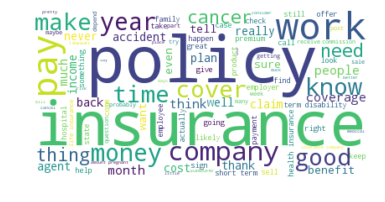

In [26]:
create_cloud(cmts)

In [30]:
# Remove unnecessary frequent words and do topic modeling
remove = ['know','need','people', 'think','also', 'really', 'well','take','tell', 'sure', 'even','going','give','come','still','keep',
         'maybe','try','use','part']
tokens = final_tokens(cmts,remove)
get_topics(tokens,10)

C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

Topic 1: employee make business commission market care full next sell glassdoor
Topic 2: right situation definitely good kind break sound happen change move
Topic 3: anything high comment agent paycheck money duck department call buy
Topic 4: insurance company work claim offer little many illegal much get_pay
Topic 5: chart buying_pressure edit back fairly stocks help piss pullback relatively
Topic 6: hospital month something pretty pay thing happen friend great benefit
Topic 7: thought bottom base_commission feel delete kid place reason working thinking
Topic 8: money week time back plan actually surgery accidental price injure
Topic 9: dental policy short_term cancer disability income similar insurance sign save
Topic 10: work look case want time injury policy interview healthcare include


C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

# topic modling of negative comments

In [31]:
os.chdir(r'E:\Capstone\aflac\final files\reddit')
df = pd.read_csv('reddit_sentiments.csv')

In [32]:
neg_comments = df[df['Sentiment']=='Negative']['comments']

In [33]:
neg_comments.shape

(104,)

In [34]:
clean_neg_comments = []
for c in neg_comments:
    cleaned = clean(c)
    if len(cleaned)>0:
        clean_neg_comments.append(cleaned)

In [35]:
clean_neg_tokens = []
for c in clean_neg_comments:
    tokens = word_tokenize(c)
    clean_neg_tokens.append(tokens)
    if random.random() > .99:
            print(tokens)

['problem', 'decide', 'keep', 'coverage', 'assume', 'second', 'fairly', 'soon', 'derail', 'thyroid', 'issue', 'maybe', 'cost', 'effective']


['insurance', 'money', 'company', 'work', 'month', 'make', 'think', 'people', 'coverage', 'claim', 'cover', 'scam', 'income', 'policy', 'cancer', 'never', 'even', 'know', 'delete', 'time', 'spouse', 'agent', 'good', 'really', 'something', 'take', 'sign', 'benefit', 'family', 'probably', 'need', 'year', 'want', 'plan', 'person', 'hospital', 'type', 'keep', 'receive', 'happen', 'accident', 'miss', 'care', 'come', 'give', 'still', 'much', 'actually', 'getting', 'likely', 'medical', 'bill', 'call', 'well', 'cost', 'life', 'working', 'premium', 'option', 'hurt', 'away', 'signing', 'long', 'depend', 'maybe', 'loss', 'week', 'tell', 'close', 'part', 'back', 'pregnant', 'regular', 'amount', 'waste', 'higher', 'area', 'total', 'also', 'employee', 'thought', 'birth', 'commercial', 'example', 'bond', 'hope', 'right', 'fine', 'unfortunately', 'feel', 'means', 'injury', 'going', 'great', 'unemployment', 'qualify', 'allow', 'consider', 'help', 'question']


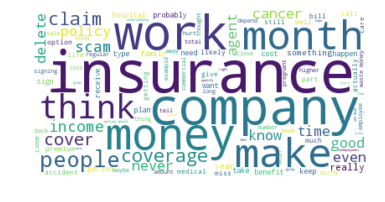

In [36]:
create_cloud(clean_neg_comments)

In [37]:
# Remove unnecessary frequent words and do topic modeling
remove = ['even', 'know','really', 'something', 'take','want','type','keep','receive','happen','miss', 'care', 'come', 'give', 'still', 'much', 'actually', 'getting', 'likely',
         'maybe', 'loss', 'week', 'tell', 'close', 'part', 'back','also','though']
tokens_new = []
for i in clean_neg_tokens:
    tokens_new.append([token for token in i if token not in remove])
get_topics(tokens_new,10)

C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

Topic 1: insurance money bond option premium company always make claim think
Topic 2: delete rich hear breast_cancer family well horrible round feel product
Topic 3: different month people year insurance away thing farther hypothetical fit
Topic 4: insurance agent cover claim month offer crash illegal marijuana leave
Topic 5: never cancer benefit scam stitch yearly consider unemployment total money
Topic 6: scam commercial brochure conditions cost think everyone company coverage leave
Topic 7: family commercial go well majority thought money people agent feel
Topic 8: company people tend winning burn house personally self sometimes talking
Topic 9: make_sense depend sick income work think spouse find le working_spouse
Topic 10: cover coverage pay days benefit qualify rest insurance_ripoff warranty long


C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\all\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(